# Spike Cascades and Brain Criticality

In [15]:
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
SPIKES_DIRECTORY = "../Data/spikes"
ERIN_DIRECTORY = "../../../erinconr/projects/fc_toolbox/results/analysis/intermediate/"

TABLES_DIRECTORY = "../../Data/giant_tables"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"

# LCF_THRESHOLD = 80
# LCF_SHADE_END = None

spikes_index = 3

In [3]:
patient_hup_ids = [
    143,
    146,
    149,
    153,
    157,
    158,
    165,
    169,
    171,
    177,
    181,
    190,
    205,
    210,
    216,
]
patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

15

## Helper functions

In [4]:
def find_taper_periods(hourly_patient_features_df, patient_hup_id):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[
        (~hourly_patient_features_df["teager_energy_delta"].isna())
        & (~hourly_patient_features_df["kuramoto_delta"].isna())
    ].emu_hour.min()

    # Get medication columns
    med_columns = [
        col for col in hourly_patient_features_df.columns if col.startswith("med_")
    ]

    # 2 day periods with 3 day gap
    before_taper_period = (start_point, start_point + 48)
    after_taper_period = (start_point + 48 + 72, start_point + 48 + 72 + 48)
    period_length_days = 2
    gap_length_days = 3

    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 3 day gap contains seizures")
        # 2 day periods with 2 day gap
        before_taper_period = (start_point, start_point + 48)
        after_taper_period = (start_point + 48 + 48, start_point + 48 + 48 + 48)
        period_length_days = 2
        gap_length_days = 2

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 2 day gap contains seizures")
        # 2 day periods with 1 day gap
        before_taper_period = (start_point, start_point + 48)
        after_taper_period = (start_point + 48 + 24, start_point + 48 + 24 + 48)
        period_length_days, gap_length_days = 2, 1

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 1 day gap contains seizures")
        # 1 day periods with 2 day gap
        before_taper_period = (start_point, start_point + 24)
        after_taper_period = (start_point + 24 + 48, start_point + 24 + 48 + 24)
        period_length_days = 1
        gap_length_days = 1

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("1 day periods with 2 day gap contains seizures")
        # 1 day periods with 1 day gap
        before_taper_period = (start_point, start_point + 24)
        after_taper_period = (start_point + 24 + 24, start_point + 24 + 24 + 24)
        period_length_days = 1
        gap_length_days = 1

    # check if the entire two periods contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("1 day periods with 1 day gap contains seizures")
        print("Last straw, both periods contain seizures, discard!")
        return (np.nan, np.nan), (np.nan, np.nan), None, None

    return before_taper_period, after_taper_period, period_length_days, gap_length_days

In [5]:
def plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(13, 1, figsize=(10, 20), sharex=True)

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(
                hourly_patient_features_df["emu_hour"], normalized_data, label=label
            )

    # Adding horizontal bars
    ax[0].hlines(
        1, before_taper_period[0], before_taper_period[1], color="green", linewidth=2
    )
    ax[0].hlines(
        1, after_taper_period[0], after_taper_period[1], color="red", linewidth=2
    )

    # Adding text annotations
    ax[0].text(
        (before_taper_period[0] + before_taper_period[1]) / 2,
        1,
        "before taper",
        ha="center",
        va="bottom",
    )
    ax[0].text(
        (after_taper_period[0] + after_taper_period[1]) / 2,
        1,
        "after taper",
        ha="center",
        va="bottom",
    )

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Normalized Load")
    ax[0].set_ylim([0, 1.3])
    ax[0].legend()
    ax[0].set_title("Individual AEDs")

    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")

    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_all"],
    )
    for idx in seizure_hours:
        ax[2].axvline(x=idx, color="red", linestyle="dotted")

    ax[2].set_ylabel("Total Spikes")
    ax[2].set_title("All Spikes")

    # Plotting Teager energy for all frequency bands
    bands = ["delta", "theta", "alpha", "beta", "gamma"]
    for i, band in enumerate(bands):
        ax[i + 3].plot(
            hourly_patient_features_df["emu_hour"],
            hourly_patient_features_df["teager_energy_" + band],
        )
        for idx in seizure_hours:
            ax[i + 3].axvline(x=idx, color="red", linestyle="dotted")

        ax[i + 3].set_ylabel("Teager Energy")
        ax[i + 3].set_title(f"Teager Energy ({band.capitalize()} Band)")

    # Plotting Kuramoto for all frequency bands
    for i, band in enumerate(bands):
        ax[i + 8].plot(
            hourly_patient_features_df["emu_hour"],
            hourly_patient_features_df["kuramoto_" + band],
        )
        for idx in seizure_hours:
            ax[i + 8].axvline(x=idx, color="red", linestyle="dotted")

        ax[i + 8].set_ylabel("R")
        ax[i + 8].set_title(f"Kuramoto Order Parameter ({band.capitalize()} Band)")

    ax[12].set_xlabel("Time (hours)")

    plt.tight_layout()
    plt.show()

In [6]:
def calculate_spike_cascade_distribution(patient_spikes_segment):
    patient_spikes_segment = patient_spikes_segment.copy()
    patient_spikes_segment[np.isnan(patient_spikes_segment)] = 0

    # # make every element that's greater than 0 equal to 1
    # patient_spikes_segment[patient_spikes_segment > 0] = 1

    # Compute the size of spike cascade for each window
    cascade_sizes = np.sum(patient_spikes_segment, axis=0)

    # Compute the frequency of each size
    unique_sizes, counts = np.unique(cascade_sizes, return_counts=True)

    # Compute the probabilities
    probabilities = counts / len(cascade_sizes)

    return unique_sizes, probabilities

In [7]:
# Load ./data/ieeg_starts.xlsx into a dataframe
ieeg_starts_df = pd.read_excel("../../Data/ieeg_starts.xlsx")
ieeg_starts_df

,hup_id,ieeg_start
0,225,38.024167
1,224,37.582778
2,223,32.985556
3,221,37.690000
4,219,33.396667
...,...,...
75,141,37.249444
76,140,35.197500
77,139,37.151667
78,138,37.529444


## Taper day by day

2 day periods with 3 day gap contains seizures
Patient 143 taper transition period: 0 - 150


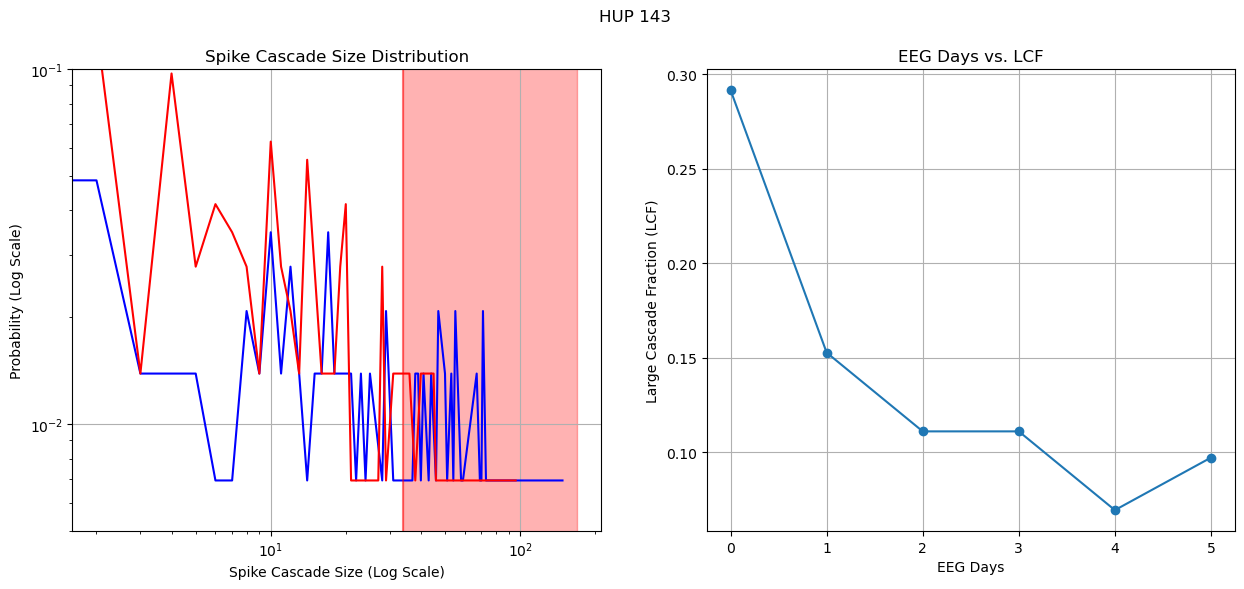

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
Patient 146 taper transition period: 0 - 120


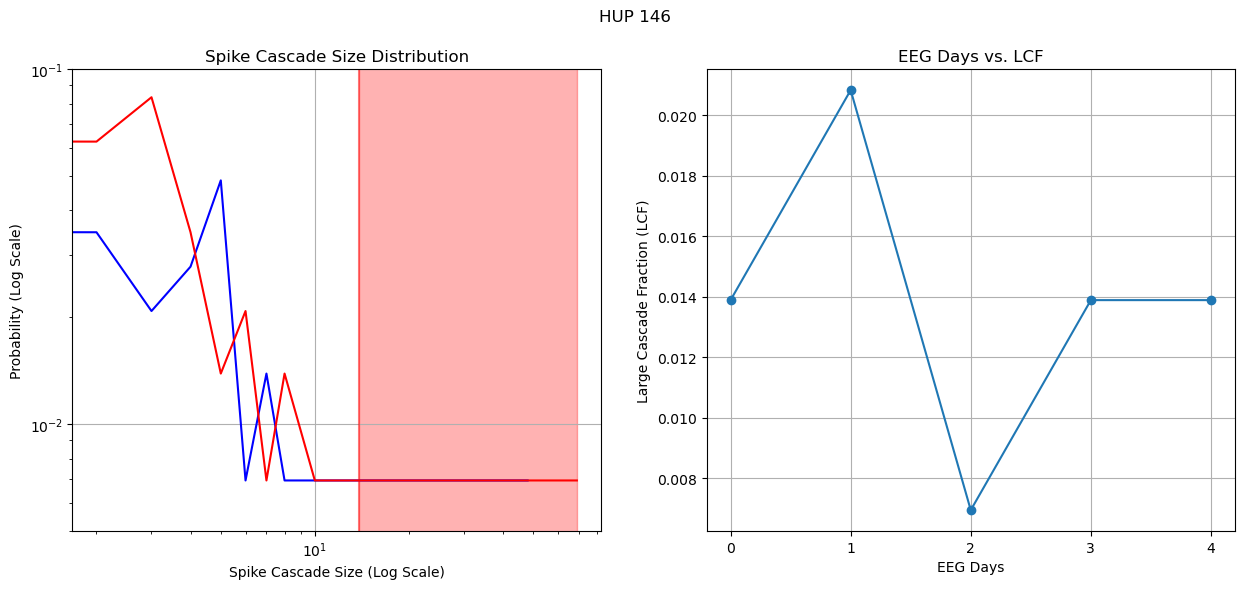

Patient 149 taper transition period: 0 - 168


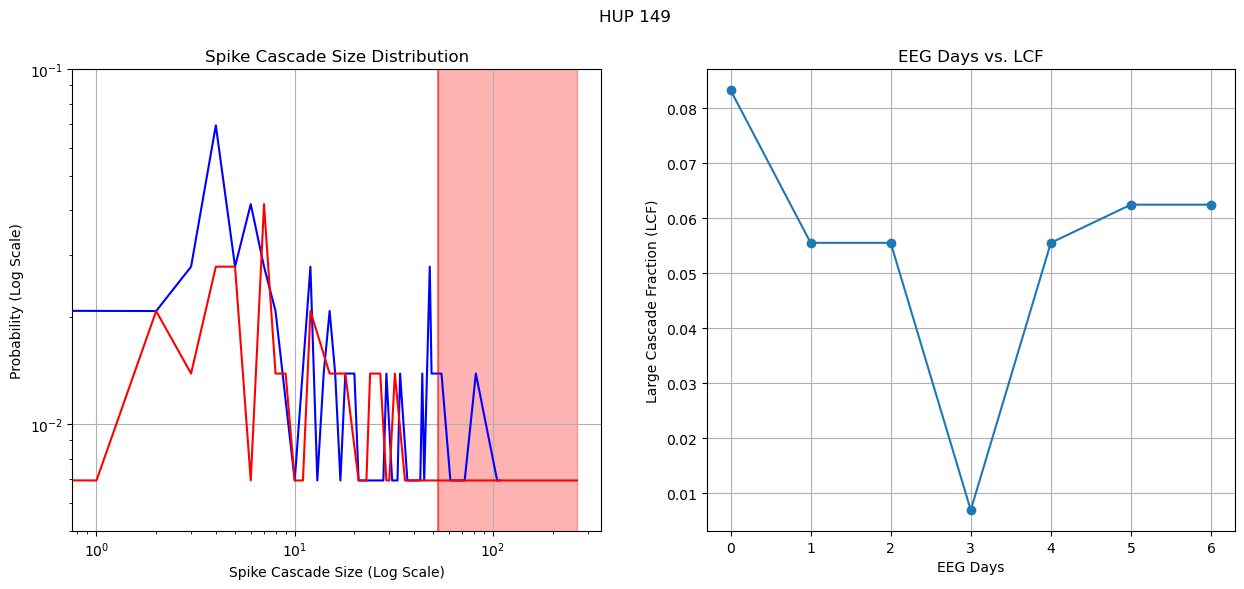

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 153 taper transition period: 0 - 96


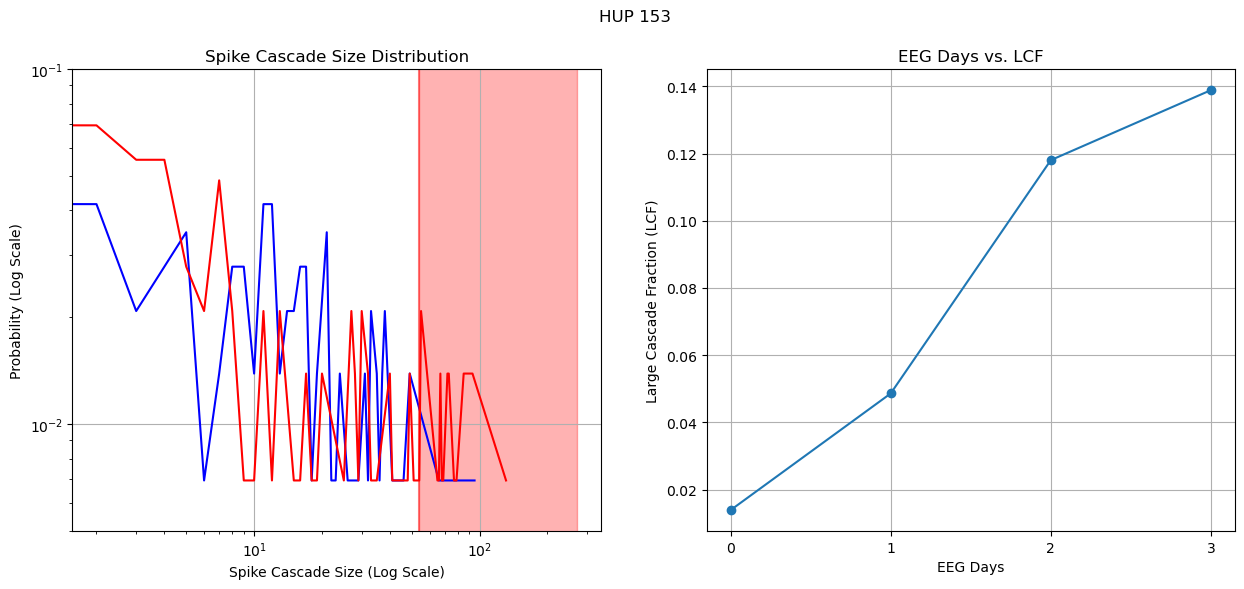

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 157 taper transition period: 0 - 72


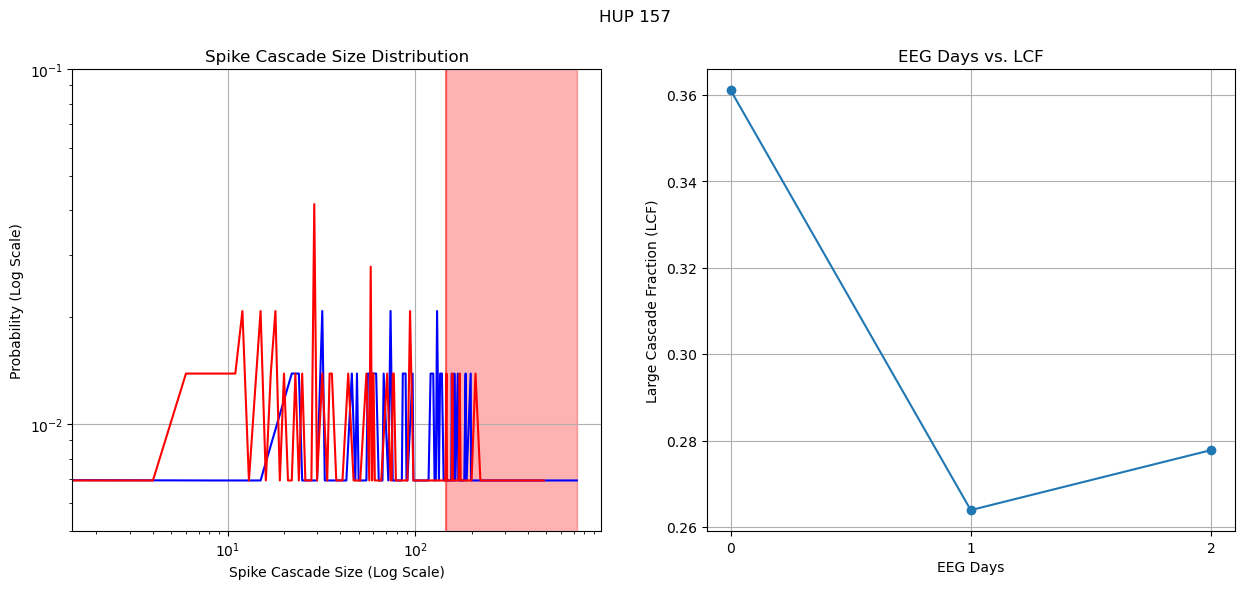

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 158 taper transition period: 0 - 75


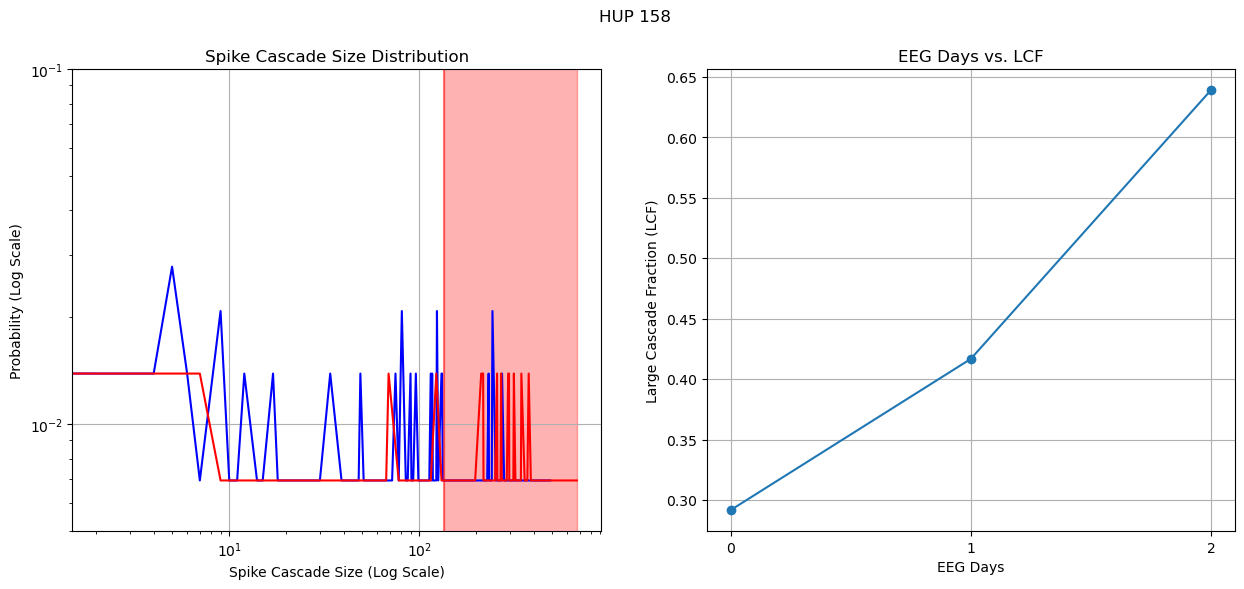

Patient 165 taper transition period: 0 - 168


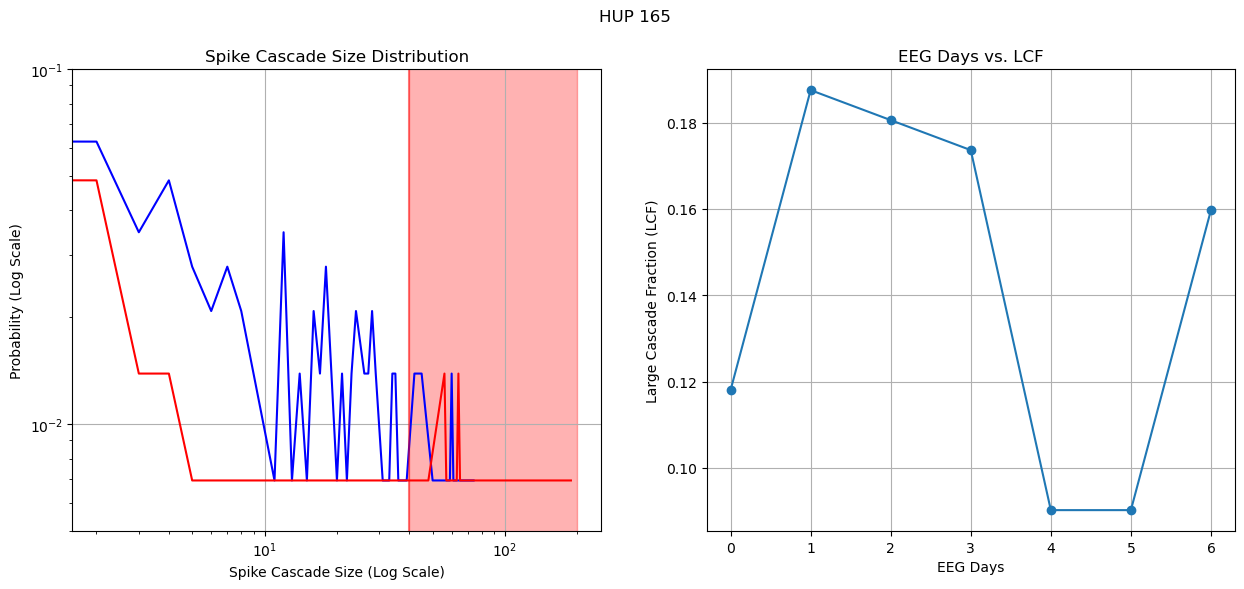

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 169 taper transition period: 0 - 96


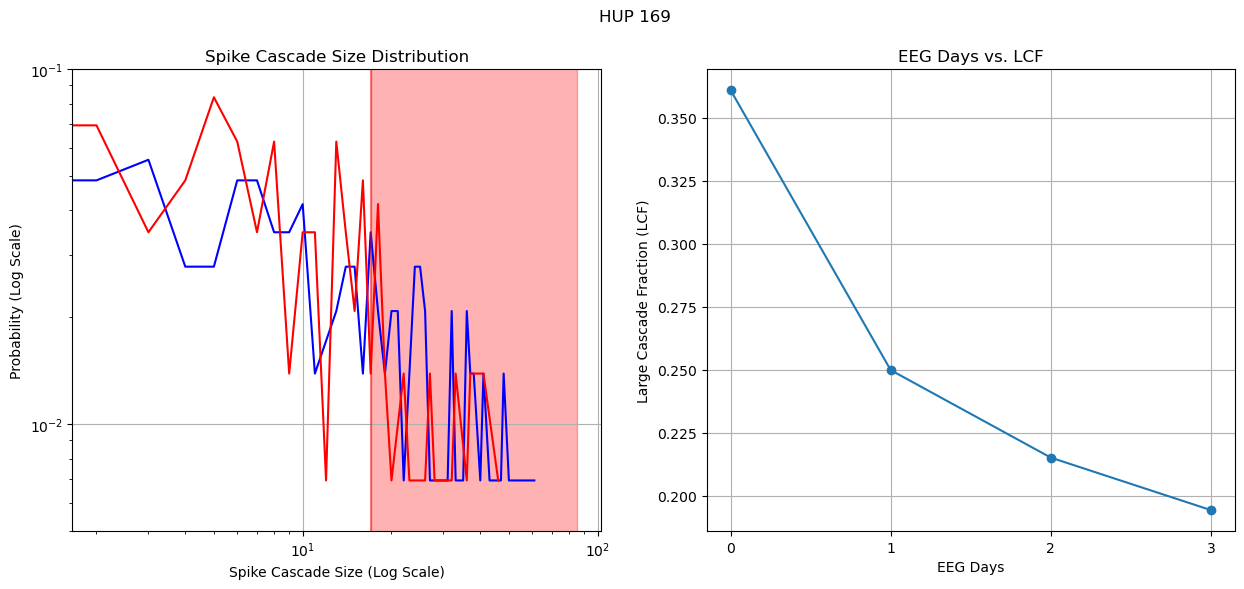

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 171 taper transition period: 0 - 96


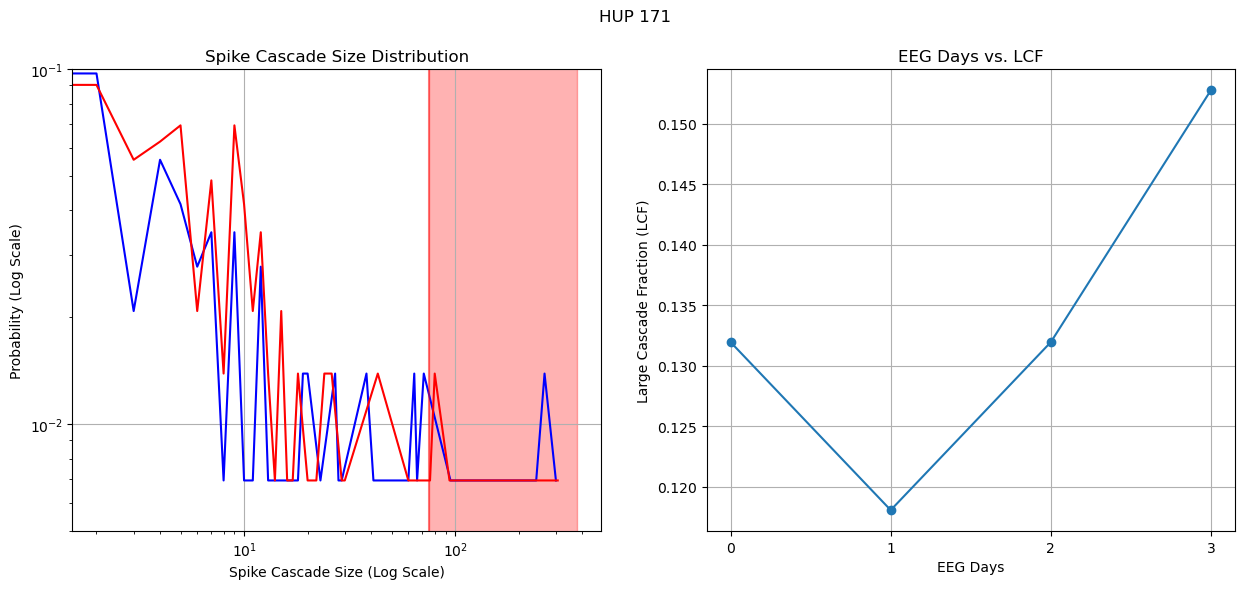

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 177 taper transition period: 0 - 96


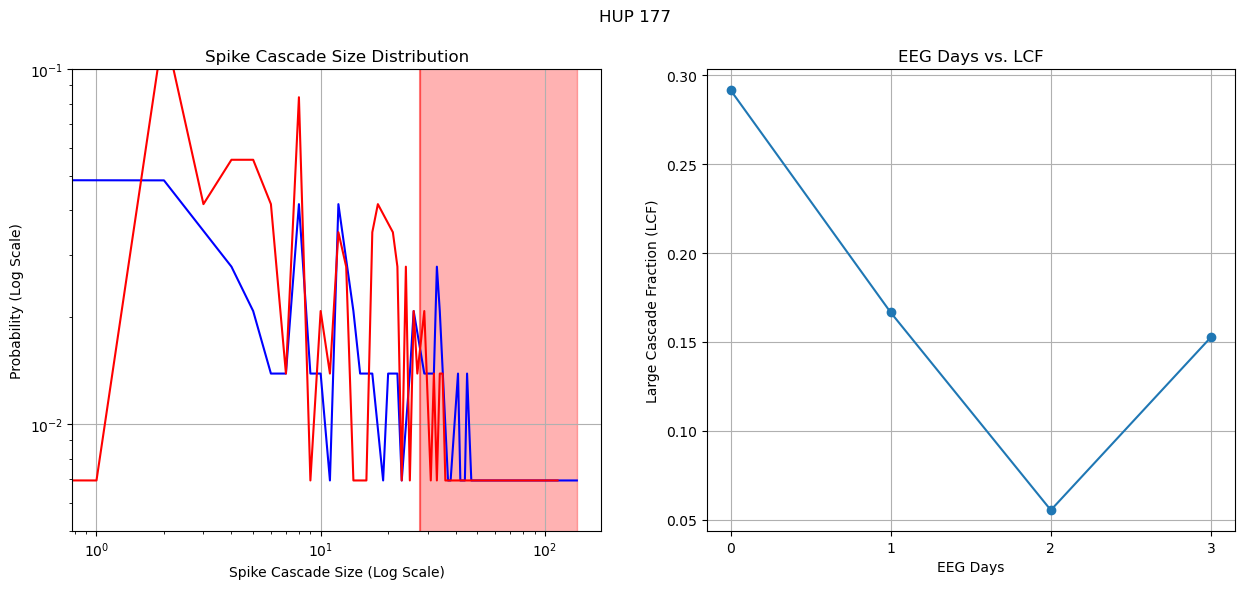

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 181 taper transition period: 0 - 72


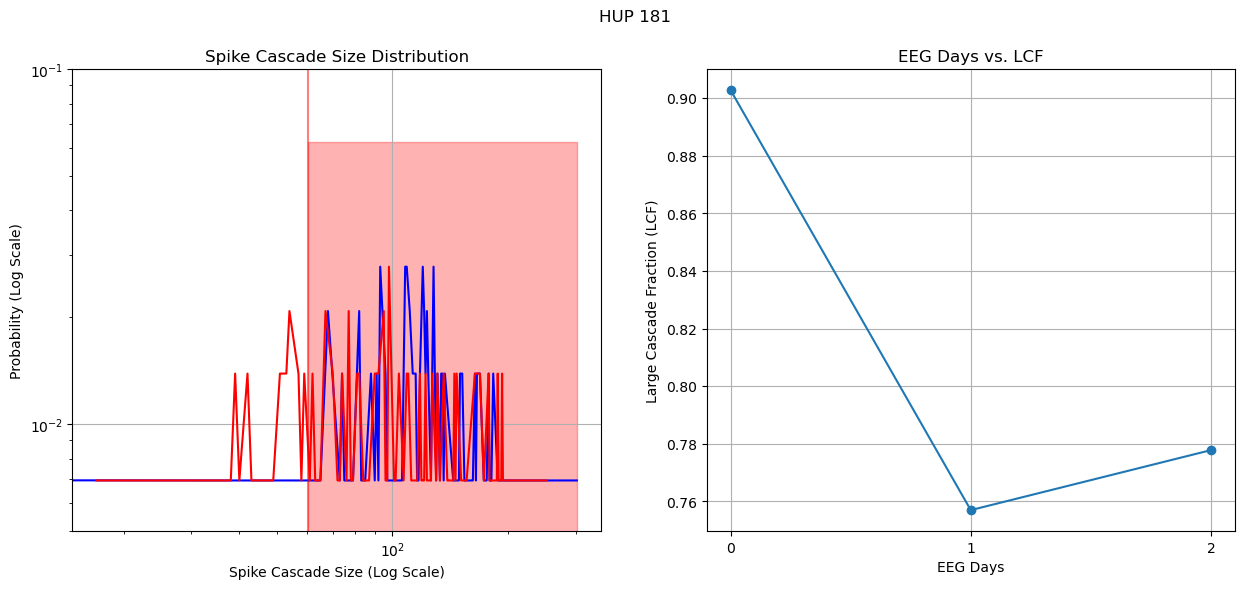

2 day periods with 3 day gap contains seizures
Patient 190 taper transition period: 0 - 144


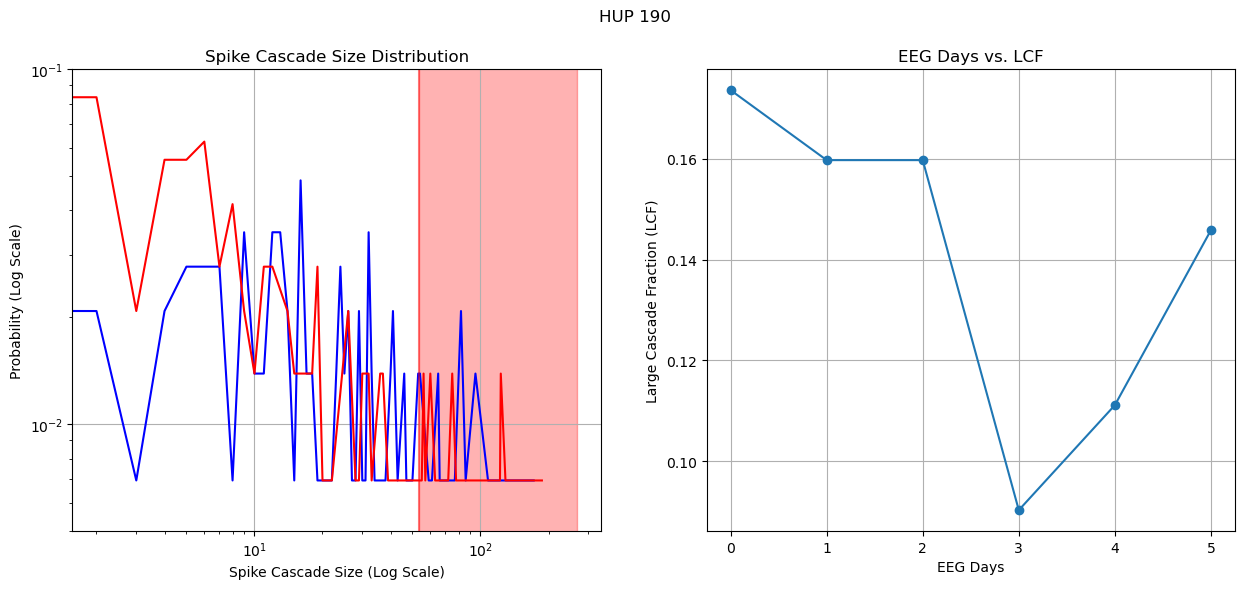

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 205 taper transition period: 0 - 96


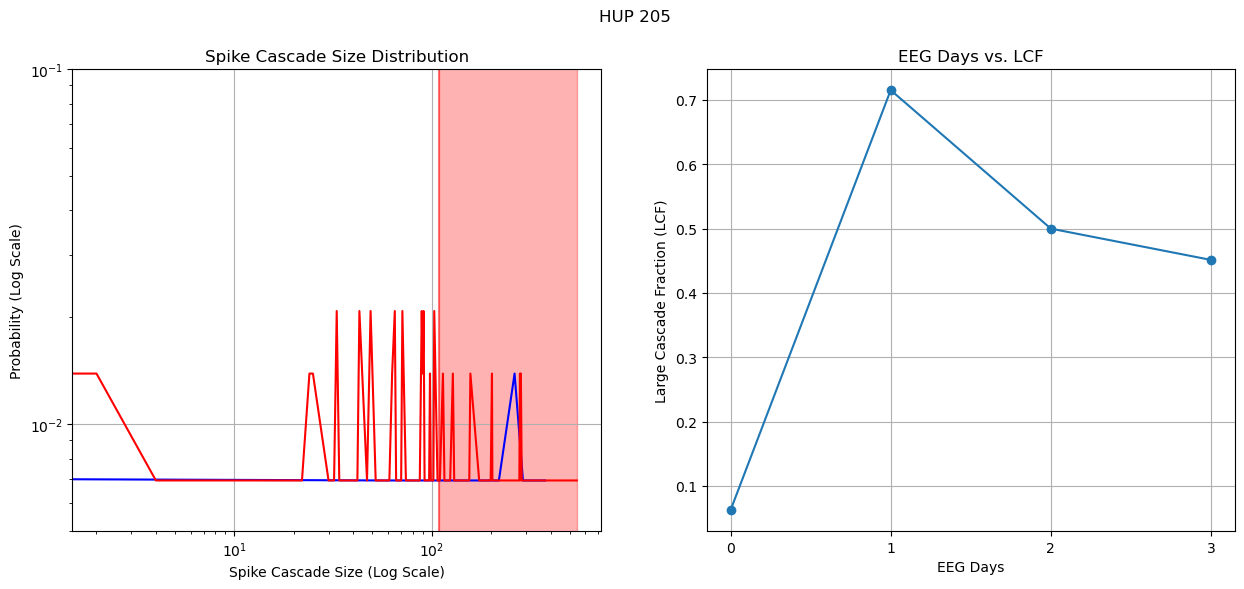

2 day periods with 3 day gap contains seizures
Patient 210 taper transition period: 0 - 163


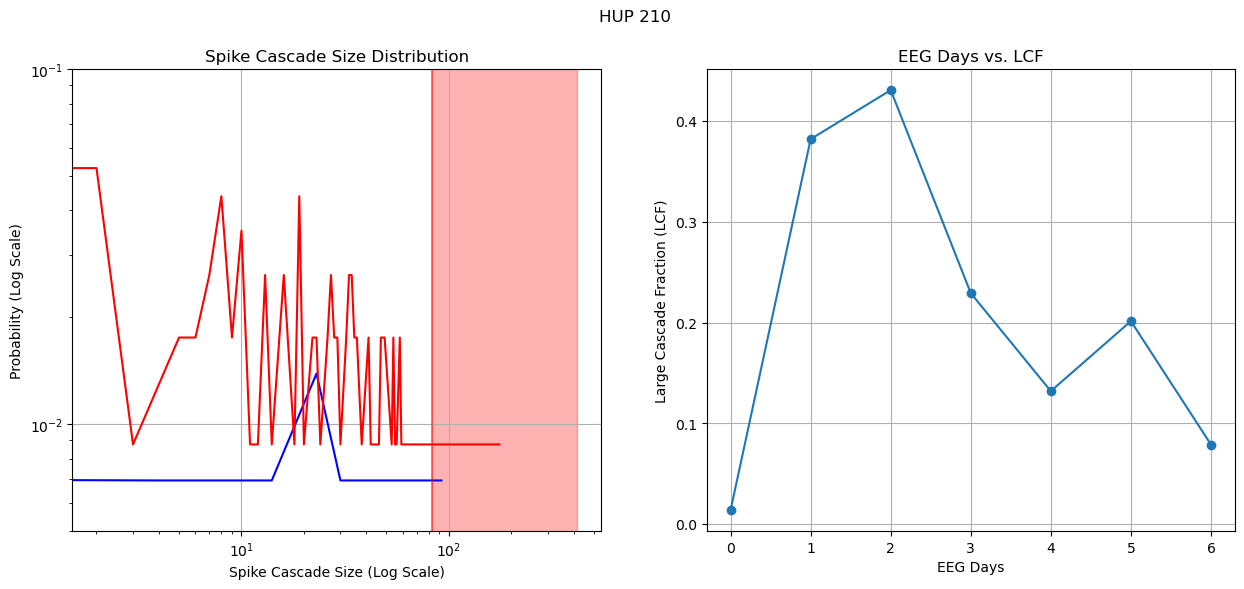

2 day periods with 3 day gap contains seizures
Patient 216 taper transition period: 0 - 144


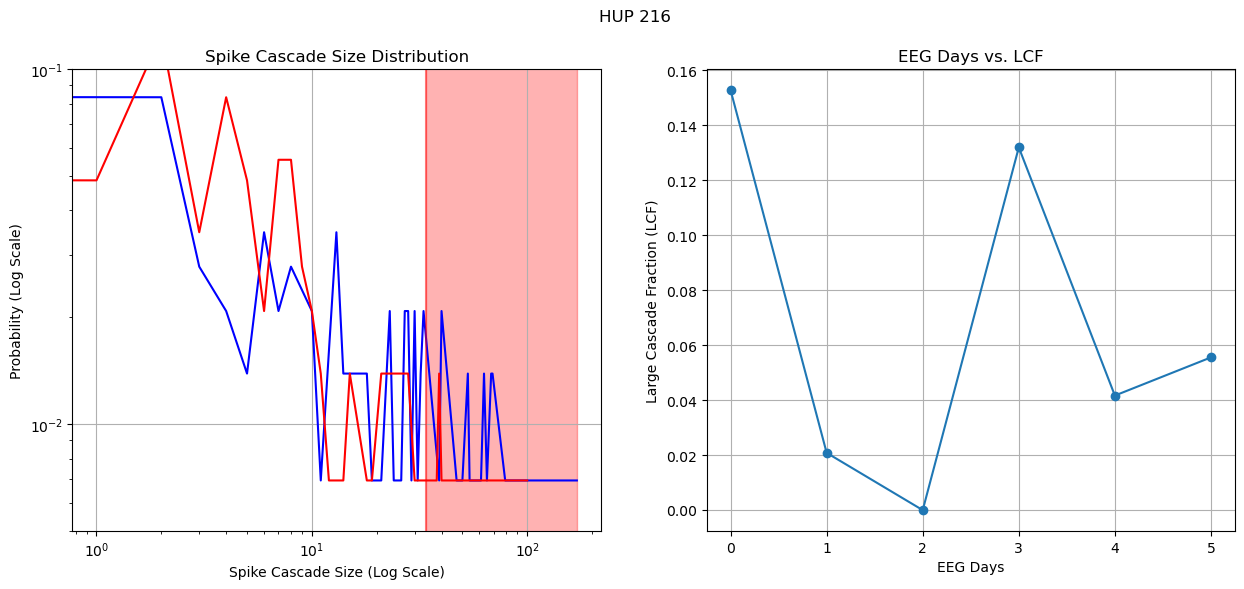

In [21]:
for patient_hup_id in patient_hup_ids:
    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    before_taper_period, after_taper_period, _, _ = find_taper_periods(
        hourly_patient_features_df, patient_hup_id
    )

    taper_transition_period = (before_taper_period[1], after_taper_period[1])

    print(
        f"Patient {patient_hup_id} taper transition period: 0 - {taper_transition_period[1] - aligned_emu_start_time_hrs}"
    )

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    # start_index = (taper_transition_period[0] - aligned_emu_start_time_hrs) * 6
    start_index = 0
    end_index = (taper_transition_period[1] - aligned_emu_start_time_hrs) * 6

    ###############################
    # Read in the spike times
    ###############################
    mat_file = scipy.io.loadmat(
        os.path.join(ERIN_DIRECTORY, f"HUP{str(patient_hup_id)}.mat")
    )
    mat_file = mat_file["summ"][0][0]
    patient_spikes = mat_file[spikes_index][:, start_index:end_index]

    unique_sizes_all, probabilities_all = calculate_spike_cascade_distribution(
        patient_spikes
    )
    # Update the LCF_THRESHOLD to be 50% of the largest size for this patient
    LCF_THRESHOLD = 0.2 * unique_sizes_all.max()

    ###############################
    # Plot cascade distribution
    ###############################
    max_eeg_days = round(patient_spikes.shape[1] / 6 / 24)

    # Create a multi-subplot figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    fractions = []

    cmap = plt.cm.RdYlGn
    max_prob = 0  # To keep track of max of all probabilities
    LCF_SHADE_END = 0  # To keep track of max of all unique_sizes

    for eeg_day in range(max_eeg_days):
        start_col_index = eeg_day * 6 * 24
        end_col_index = start_col_index + 6 * 24
        eeg_hour_spikes = patient_spikes[:, start_col_index:end_col_index]
        unique_sizes, probabilities = calculate_spike_cascade_distribution(
            eeg_hour_spikes
        )

        mask = unique_sizes > LCF_THRESHOLD
        fraction = sum(probabilities[mask])
        fractions.append(fraction)

        day_norm = eeg_day / max_eeg_days
        day_color = cmap(1.0 - day_norm)

        if eeg_day == 0:
            axs[0].loglog(unique_sizes, probabilities, "-", color="b")
        elif eeg_day == max_eeg_days - 1:
            axs[0].loglog(unique_sizes, probabilities, "-", color="r")
        # axs[0].scatter(unique_sizes, probabilities, color=day_color)
        # axs[0].set_xscale("log")
        # axs[0].set_yscale("log")
        # axs[0].loglog(unique_sizes, probabilities, "-", color=day_color)

        # Update the max_prob if the current max probability is larger
        max_prob = max(max_prob, probabilities.max())
        # Update the LCF_SHADE_END if the current max unique_sizes is larger
        LCF_SHADE_END = max(LCF_SHADE_END, unique_sizes.max())

    axs[0].axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
    axs[0].fill_betweenx(
        [0, max_prob], LCF_THRESHOLD, LCF_SHADE_END, color="red", alpha=0.3
    )

    axs[0].set_title(f"Spike Cascade Size Distribution")
    axs[0].set_xlabel("Spike Cascade Size (Log Scale)")
    axs[0].set_ylabel("Probability (Log Scale)")
    axs[0].set_ylim(0.005, 0.1)
    axs[0].grid(True)

    # After the loop, plot the second subplot
    axs[1].plot(range(max_eeg_days), fractions, "o-")
    axs[1].set_xlabel("EEG Days")
    axs[1].set_ylabel("Large Cascade Fraction (LCF)")
    axs[1].set_title(f"EEG Days vs. LCF")

    axs[1].set_xticks(range(max_eeg_days))

    axs[1].grid(True)

    # Add title to the figure
    fig.suptitle(f"HUP {patient_hup_id}")

    # Show the whole figure
    plt.show()

### Overall distribution

2 day periods with 3 day gap contains seizures
Patient 143 taper transition period: 0 - 150


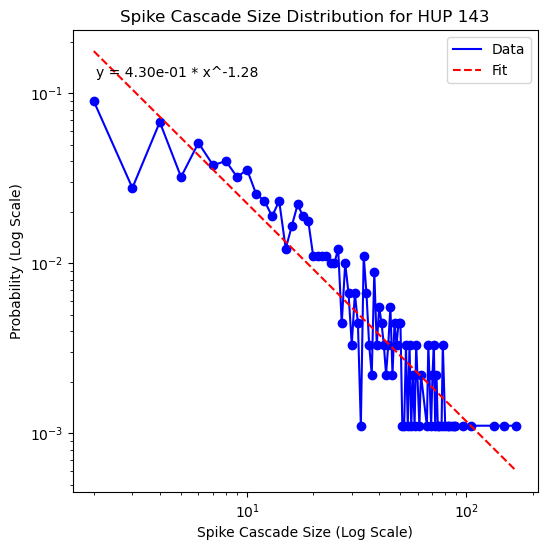

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
Patient 146 taper transition period: 0 - 120


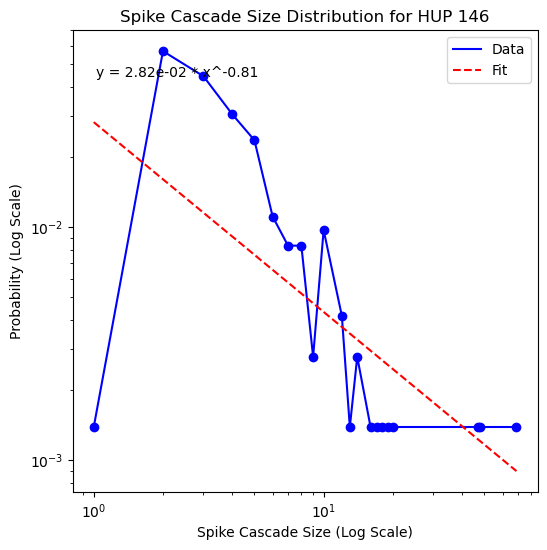

Patient 149 taper transition period: 0 - 168


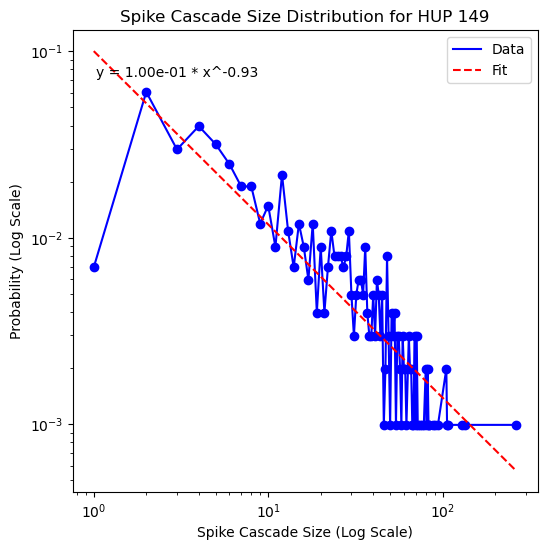

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 153 taper transition period: 0 - 96


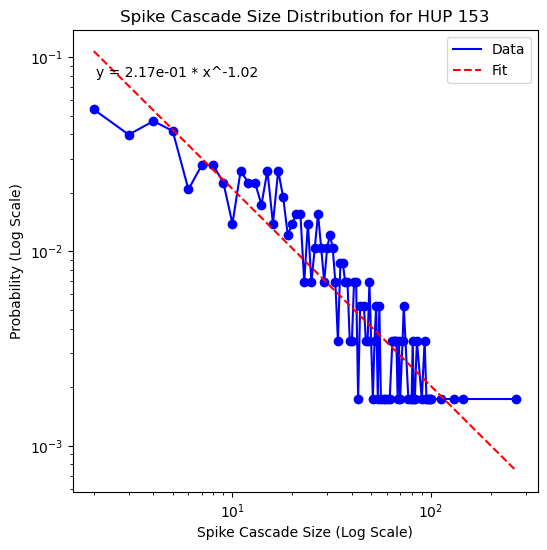

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 157 taper transition period: 0 - 72


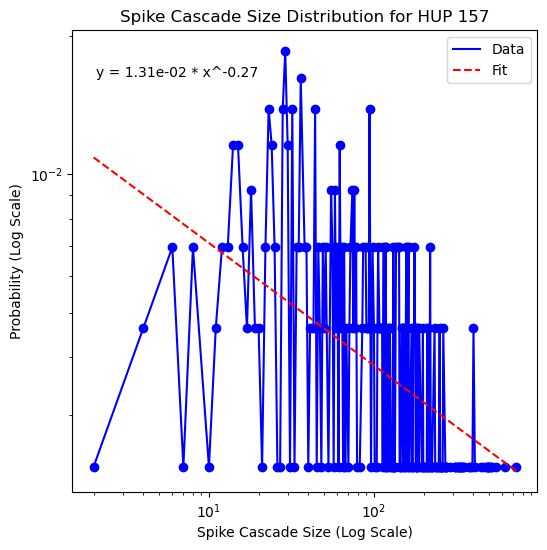

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 158 taper transition period: 0 - 75


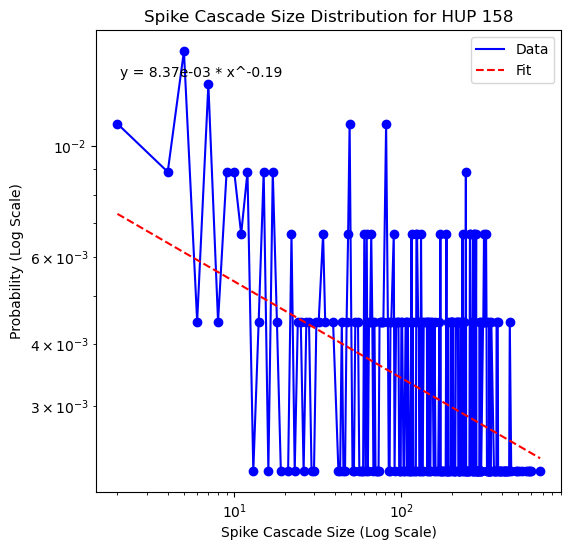

Patient 165 taper transition period: 0 - 168


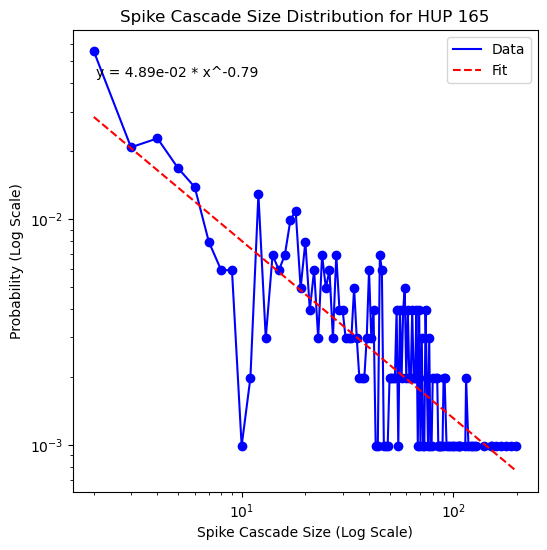

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 169 taper transition period: 0 - 96


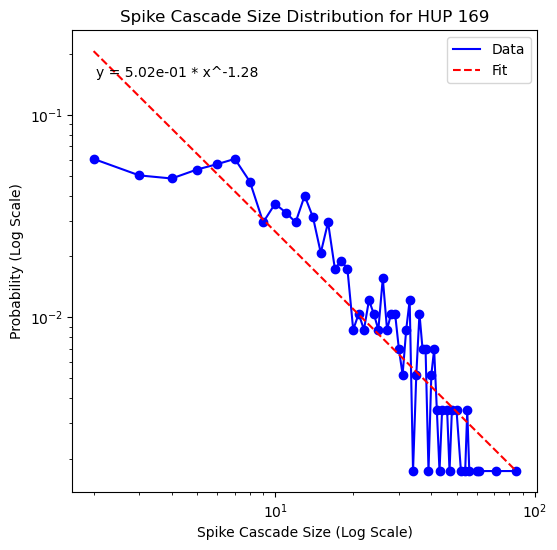

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 171 taper transition period: 0 - 96


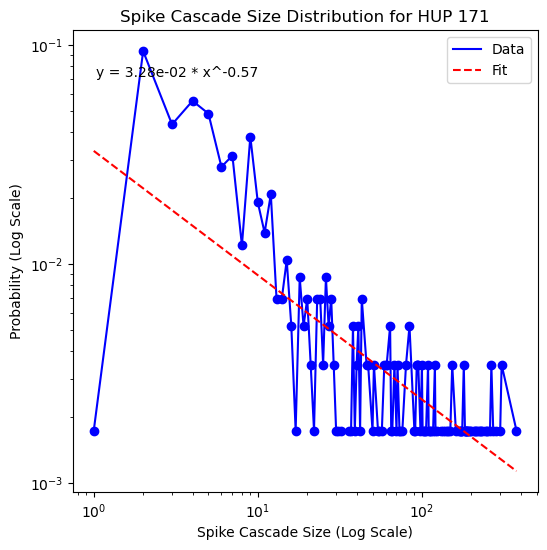

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 177 taper transition period: 0 - 96


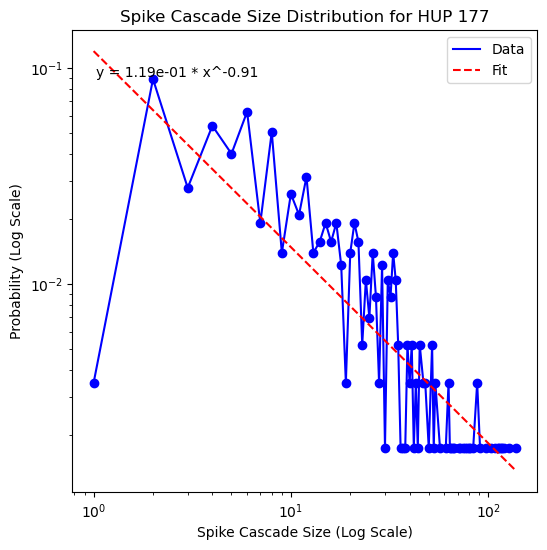

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
Patient 181 taper transition period: 0 - 72


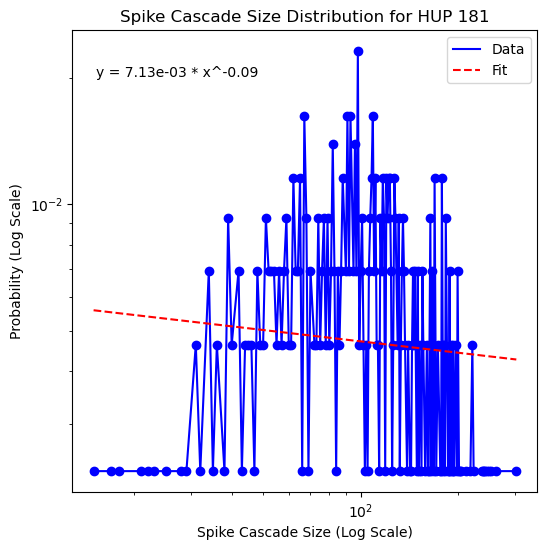

2 day periods with 3 day gap contains seizures
Patient 190 taper transition period: 0 - 144


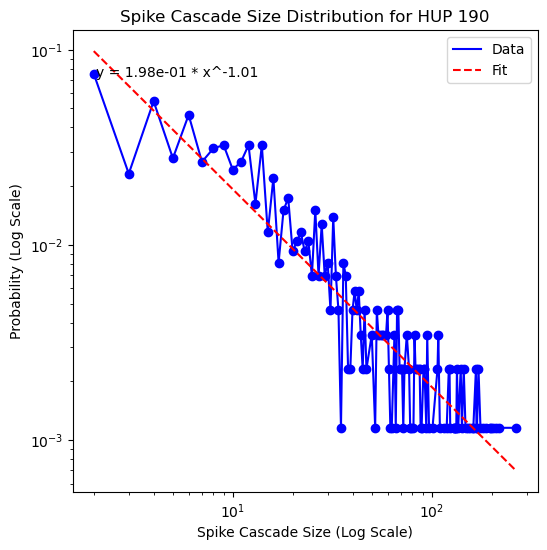

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
Patient 205 taper transition period: 0 - 96


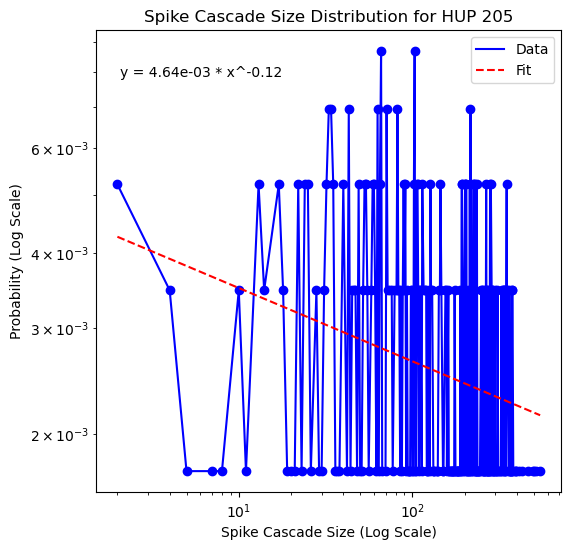

2 day periods with 3 day gap contains seizures
Patient 210 taper transition period: 0 - 163


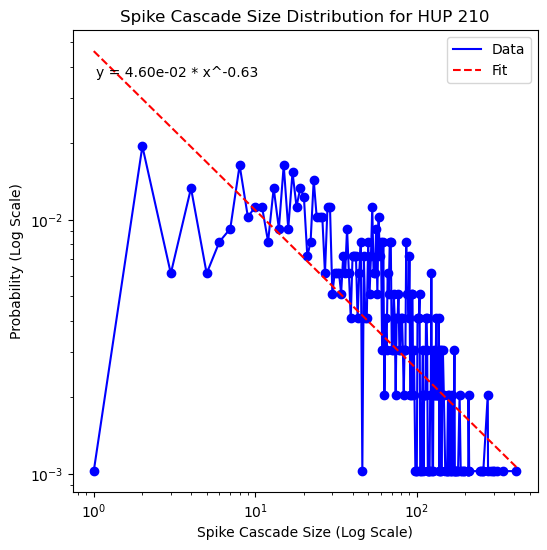

2 day periods with 3 day gap contains seizures
Patient 216 taper transition period: 0 - 144


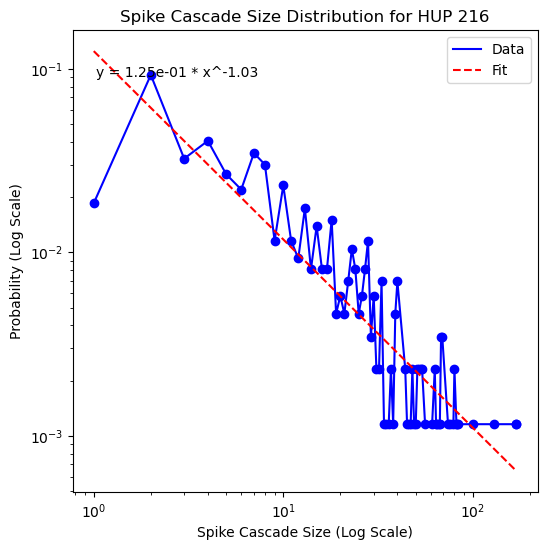

In [18]:
for patient_hup_id in patient_hup_ids:
    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    before_taper_period, after_taper_period, _, _ = find_taper_periods(
        hourly_patient_features_df, patient_hup_id
    )

    taper_transition_period = (before_taper_period[1], after_taper_period[1])

    print(
        f"Patient {patient_hup_id} taper transition period: 0 - {taper_transition_period[1] - aligned_emu_start_time_hrs}"
    )

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    # start_index = (taper_transition_period[0] - aligned_emu_start_time_hrs) * 6
    start_index = 0
    end_index = (taper_transition_period[1] - aligned_emu_start_time_hrs) * 6

    ###############################
    # Read in the spike times
    ###############################
    mat_file = scipy.io.loadmat(
        os.path.join(ERIN_DIRECTORY, f"HUP{str(patient_hup_id)}.mat")
    )
    mat_file = mat_file["summ"][0][0]
    patient_spikes = mat_file[spikes_index][:, start_index:end_index]

    unique_sizes_all, probabilities_all = calculate_spike_cascade_distribution(
        patient_spikes
    )
    # # Update the LCF_THRESHOLD to be 50% of the largest size for this patient
    # LCF_THRESHOLD = 0.1 * unique_sizes_all.max()
    # Plot the distribution
    unique_sizes, probabilities = calculate_spike_cascade_distribution(patient_spikes)

    # Filter out zero values
    non_zero_indices = unique_sizes > 0
    filtered_unique_sizes = unique_sizes[non_zero_indices]
    filtered_probabilities = probabilities[non_zero_indices]

    # Log-transform the filtered data
    log_unique_sizes = np.log(filtered_unique_sizes)
    log_probabilities = np.log(filtered_probabilities)

    # Perform linear regression on the log-transformed data
    slope, intercept, _, _, _ = linregress(log_unique_sizes, log_probabilities)

    # Generate a line for plotting
    log_fit_line = slope * log_unique_sizes + intercept
    fit_line = np.exp(log_fit_line)

    # Plot the log-log scatter and the fit line
    plt.figure(figsize=(6, 6))
    plt.scatter(filtered_unique_sizes, filtered_probabilities, c="b")
    plt.loglog(filtered_unique_sizes, filtered_probabilities, "b-", label="Data")
    plt.loglog(filtered_unique_sizes, fit_line, "r--", label="Fit")  # Fit line
    plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
    plt.xlabel("Spike Cascade Size (Log Scale)")
    plt.ylabel("Probability (Log Scale)")

    # Annotate with the equation
    annotation = f"y = {np.exp(intercept):.2e} * x^{slope:.2f}"
    plt.annotate(annotation, xy=(0.05, 0.9), xycoords="axes fraction")

    plt.legend()
    plt.show()

    # plt.figure(figsize=(5, 5))
    # plt.scatter(unique_sizes, probabilities, c="b")
    # plt.xscale("log")
    # plt.yscale("log")
    # plt.loglog(unique_sizes, probabilities, "b-")
    # # plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
    # # if LCF_SHADE_END is None:
    # #     LCF_SHADE_END = max(unique_sizes)
    # # plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

    # plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
    # plt.xlabel("Spike Cascade Size (Log Scale)")
    # plt.ylabel("Probability (Log Scale)")
    # plt.show()

### Day by day

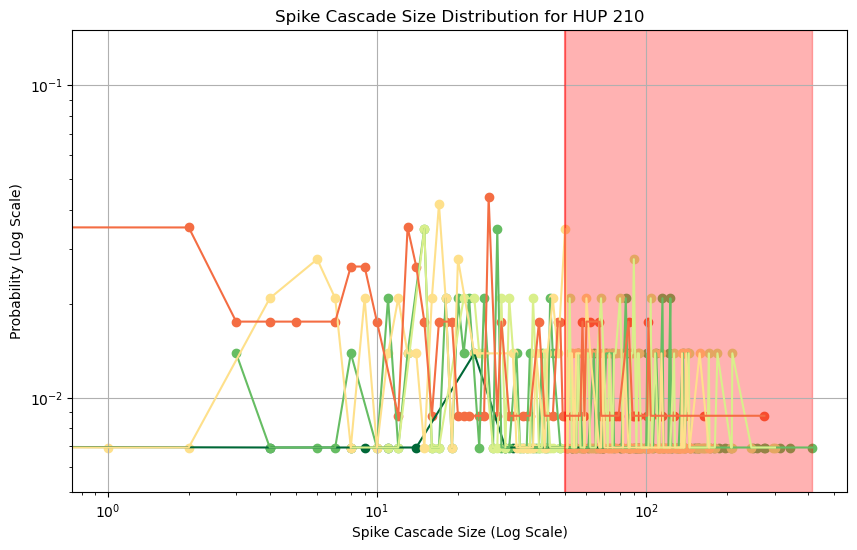

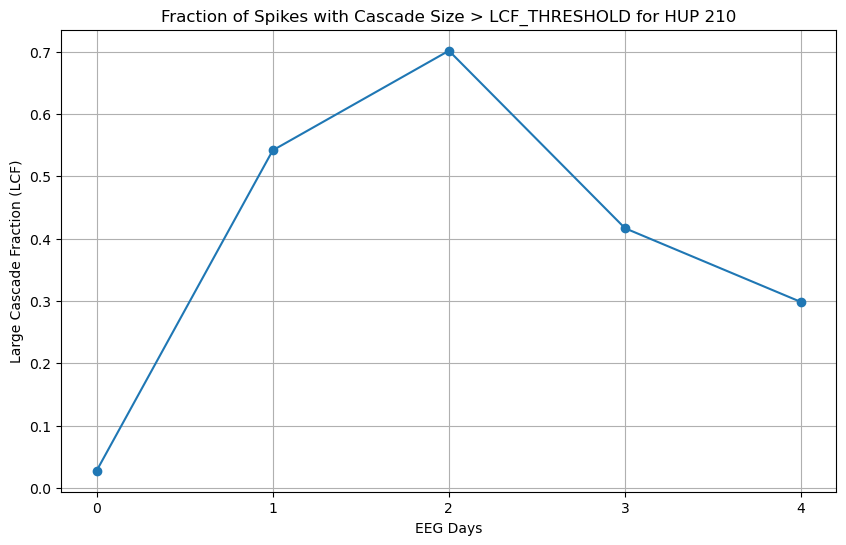

In [10]:
max_eeg_days = round(patient_spikes.shape[1] / 6 / 24)
plt.figure(figsize=(10, 6))

# Create empty list to hold fractions
fractions = []

# create a color map
cmap = plt.cm.RdYlGn

for eeg_day in range(max_eeg_days):
    start_col_index = eeg_day * 6 * 24
    end_col_index = start_col_index + 6 * 24
    eeg_hour_spikes = patient_spikes[:, start_col_index:end_col_index]
    unique_sizes, probabilities = calculate_spike_cascade_distribution(eeg_hour_spikes)

    # Calculate fraction of spikes with cascade size more than LCF_THRESHOLD
    mask = unique_sizes > LCF_THRESHOLD
    fraction = sum(probabilities[mask])
    fractions.append(fraction)

    # normalize the day with max_days to get a color
    day_norm = eeg_day / max_eeg_days
    day_color = cmap(
        1.0 - day_norm
    )  # use 1.0 - day_norm to make it transition from green to red

    plt.scatter(unique_sizes, probabilities, color=day_color)  # use the color argument
    plt.xscale("log")
    plt.yscale("log")
    plt.loglog(unique_sizes, probabilities, "-", color=day_color)


plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.ylim(0.005, 0.15)
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")
plt.grid(True)
plt.show()

# After the loop
plt.figure(figsize=(10, 6))
plt.plot(range(max_eeg_days), fractions, "o-")
plt.xlabel("EEG Days")
plt.ylabel("Large Cascade Fraction (LCF)")
plt.title(
    f"Fraction of Spikes with Cascade Size > LCF_THRESHOLD for HUP {patient_hup_id}"
)

# Set the x-ticks to be integers
plt.xticks(range(max_eeg_days))

plt.grid(True)
plt.show()

### Before/after taper

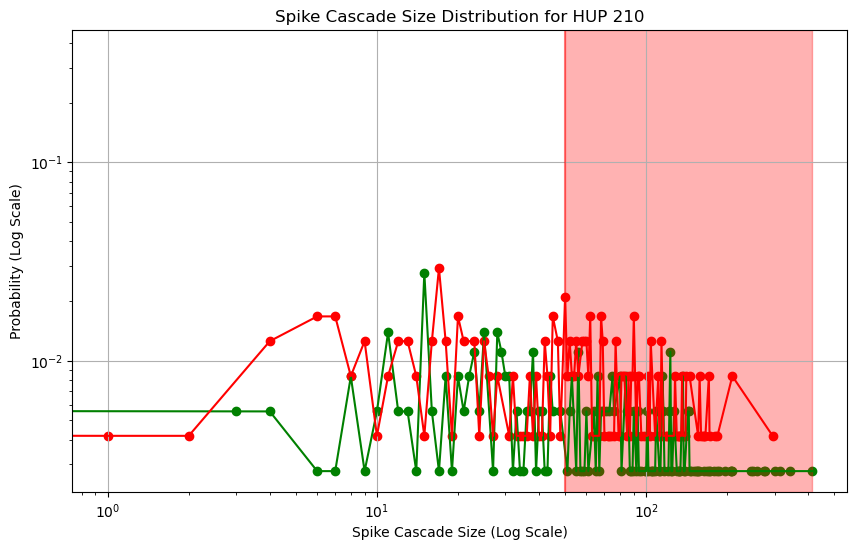

In [11]:
before_taper_period = (0, 60 * 6)
after_taper_period = (60 * 6 + 1, 600)

plt.figure(figsize=(10, 6))

# Plot the distribution
unique_sizes_before, probabilities_before = calculate_spike_cascade_distribution(
    patient_spikes[:, before_taper_period[0] : before_taper_period[1]]
)

plt.scatter(unique_sizes_before, probabilities_before, c="g")
plt.xscale("log")
plt.yscale("log")
plt.loglog(unique_sizes_before, probabilities_before, "g-")

# Plot the distribution
unique_sizes_after, probabilities_after = calculate_spike_cascade_distribution(
    patient_spikes[:, after_taper_period[0] : after_taper_period[1]]
)

plt.scatter(unique_sizes_after, probabilities_after, c="r")
plt.xscale("log")
plt.yscale("log")
plt.loglog(unique_sizes_after, probabilities_after, "r-")


plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")
plt.grid(True)
plt.show()